In [1]:
import glob
import tensorflow
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random

from datetime import datetime
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.python.keras.engine.saving import export_saved_model
from tensorflow.python.keras.engine.saving import load_from_saved_model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential, load_model, save_model
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    print('Warning: Running in Native python environment.')

BASEDIR = "sample"
MODELFILE = BASEDIR + "/trained_model2.h5"
TRAINDIR = BASEDIR + "/train"
VALIDATIONDIR = BASEDIR + "/validation"
MODELSDIR = BASEDIR + "/models"
TESTDIR = BASEDIR + "/test/unknown"

In [2]:
# サンプル画像を表示する関数
# https://github.com/tkazusa/TensorFlowjsDemo/blob/master/keras_models/utils.py
#
# matplotlib.use('Agg')


def imshow_with_title(ax, img, title):
    ax.imshow(img / 255.)
    ax.set_title(title)
    ax.axis('off')
    return ax


def get_train_sample_info(img_itr, n):
    class_labels = {idx: label for label, idx in img_itr.class_indices.items()}
    out_imgs, out_labels = np.array([]), np.array([])
    while len(out_imgs) < n:
        images, class_idx = next(img_itr)
        labels = [class_labels[idx] for idx in class_idx]
        out_imgs = np.concatenate(
            [out_imgs, images]
        ) if out_imgs else images
        out_labels = np.concatenate(
            [out_labels, labels]
        ) if out_labels else labels
    return out_imgs[:n], out_labels[:n]


def get_pred_sample_labels(probs, class_indices):
    class_labels = {idx: label for label, idx in class_indices.items()}
    tmp = '{}:{:.3f}  /  {}:{:.3f}'
    lbls = [tmp.format(class_labels[0], 1 - p[0], class_labels[1], p[0])
            for p in probs]
    return lbls


def show_img_samples(imgs, labels, ncols=4, save_fig=None):
    n = len(imgs)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows)
    )
    for ax, img, label in zip(axes.ravel(), imgs, labels):
        ax = imshow_with_title(ax, img, label)
    if save_fig:
        fig.savefig(save_fig)
    # fig.show()


def show_train_samples_iter(img_itr, n=8):
    imgs, labels = get_train_sample_info(img_itr, n)
    show_img_samples(imgs, labels)


def show_train_samples(img_dir, classes, n=4, seed=0, save_fig=None):
    labels = []
    imgs = None
    for img_class in classes:
        labels += [img_class] * n
        data_dir = os.path.join(img_dir, 'train/{}'.format(img_class))
        now_imgs, _ = load_random_imgs(data_dir, n, seed=seed)
        imgs = now_imgs if imgs is None else np.concatenate(
            [imgs, now_imgs], axis=0
        )
    show_img_samples(imgs, labels, save_fig=save_fig)


def show_test_samples(imgs, probs, class_indices, true_labels):
    pred_labels = get_pred_sample_labels(probs, class_indices)
    labels = [p + '\n' + 'True:' + t for p, t in zip(pred_labels, true_labels)]
    show_img_samples(imgs, labels)


def ext_label_from_filepath(img_path):
    target_idx = 0
    return os.path.basename(img_path).split('_')[target_idx]


def get_rand_img_paths(data_dir, n, seed=0, with_labels=False):
    g = os.path.join(data_dir, '*.jpg')
    img_paths = glob.glob(g)
    random.seed(seed)
    random.shuffle(img_paths)
    target_paths = img_paths[:n]
    if with_labels:
        true_labels = [ext_label_from_filepath(x) for x in target_paths]
        return target_paths, true_labels
    else:
        return target_paths


def load_imgs(img_paths, target_size):
    list_imgs = [img_to_array(load_img(path, target_size=target_size))
                 for path in img_paths]
    return np.array(list_imgs)


def load_random_imgs(data_dir, n=8, seed=0, target_size=(224, 224)):
    target_paths, true_labels = get_rand_img_paths(
        data_dir, n, seed=seed, with_labels=True
    )
    imgs = load_imgs(target_paths, target_size)
    return imgs, true_labels


def adjust_ax(df, ax, ylabel):
    df.plot(ax=ax)
    ax.set_title(ylabel)
    ax.set_xlabel('epochs')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax


def plot_learningcurve(df_history):
    figsize = (12, 4)
    nrows = 1
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, lbl in zip(axes.ravel(), ('acc', 'loss')):
        df = df_history[[lbl, 'val_{}'.format(lbl)]]
        ax = adjust_ax(df, ax, ylabel=lbl)


def plot_learningcurve_from_csv(csv_filepath):
    df_history = pd.read_csv(csv_filepath)
    plot_learningcurve(df_history)

In [3]:
# 転移学習のための準備
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルを編集し、ネットワークを生成する関数の定義


def build_transfer_model(vgg16):
    # 読み出したモデルを使って、新しいモデルを作成
    model = Sequential(vgg16.layers)
    # 読み出した重みの一部は再学習しないように設定。
    # ここでは、追加する層と出力層に近い層のみを再学習
    for layer in model.layers[:15]:
        layer.trainable = False  # トータル１６層のうち１５層までの学習はFalse
    # 追加する出力部分の層を構築
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # 最適化アルゴリズムなどを指定してモデルのコンパイル
    # 既存のVGG16の重みを活かしながら現在のタスクにも重みを適用させていくため、最適化の学習率を低く(1e-4)設定している。
    model.compile(
        loss='binary_crossentropy',
        optimizer=SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )
    return model


# 定義した関数を呼び出して、ネットワークを生成
model = build_transfer_model(vgg16)
# generatorの生成
# 学習用の画像をミニバッチ単位で読み込むためのジェネレータをImageDataGeneratorで生成
# 学習用画像をロードするためのgeneratorを生成。スケール変換やデータ拡張の引数を指定
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

W0625 17:54:53.833186 4696016320 deprecation.py:506] From /Users/takahashi/.anyenv/envs/pyenv/versions/3.7.1/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0625 17:54:54.697067 4696016320 deprecation.py:323] From /Users/takahashi/.anyenv/envs/pyenv/versions/3.7.1/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
# 教師画像

img_itr_train = idg_train.flow_from_directory(
    TRAINDIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

img_itr_validation = idg_train.flow_from_directory(
    VALIDATIONDIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [5]:
# 学習を行う前の必要な準備
# モデルの損失の保存をするためのディレクトリを作る。

# モデル保存用ディレクトリの準備
model_dir = os.path.join(MODELSDIR, datetime.now().strftime('%y%m%d_%H%M'))
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)
# 保存先のディレクトリ名を表示

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

model_dir: sample/models/190625_1754


In [6]:
# 作成したディレクトリにネットワーク構造と学習時のクラスラベルを保存

# ネットワークの保存
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w')as f:
    json.dump(model.to_json(), f)

# 学習時の正解ラベルの保存
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb')as f:
    pickle.dump(img_itr_train.class_indices, f)

In [7]:
# 学習時に指定する必要のある値を事前に算出
# ミニバッチを幾つ学習した場合に１エポックとみなすかを計算する。
# 学習用、検証用をそれぞれ計算しsteps_per_epoch、validation_stepsという変数に格納する

# 何バッチ分勉強すれば１エポックかを計算（学習時に指定する必要があるため）
batch_size = 8
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)

validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

In [8]:
# モデルの重みや損失の保存を定期的に(エポック単位で)行いたいため、Callbackを利用する。
# Modelcheckpointを使って、重みを５エポックごとに保存し、CSVLoogerを使って、損失をCSV形式で出力するよう設定する。

# Callbacksの設定

cp_filepath = os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
    cp_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    period=5
)

csv_filepath = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

W0625 17:54:54.989964 4696016320 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [9]:
# 学習
n_epoch = 1

# モデルの学習
history = model.fit_generator(
    img_itr_train,
    steps_per_epoch=steps_per_epoch,
    epochs=n_epoch,  # 学習するエポック数
    validation_data=img_itr_validation,
    validation_steps=validation_steps,
    callbacks=[cp, csv])

5/5 [==============================] - 19s 4s/step - loss: 0.7241 - acc: 0.5417 - val_loss: 0.7308 - val_acc: 0.3333


In [10]:
# 予測結果を算出する（推論）
x_test, true_labels = load_random_imgs(
    TESTDIR,
    seed=1
)
x_test_preproc = preprocess_input(x_test.copy())/255.
probs = model.predict(x_test_preproc)
probs

array([[0.5334345 ],
       [0.5495645 ],
       [0.52648586],
       [0.5501025 ],
       [0.54874945],
       [0.5337072 ],
       [0.5448904 ],
       [0.514499  ]], dtype=float32)

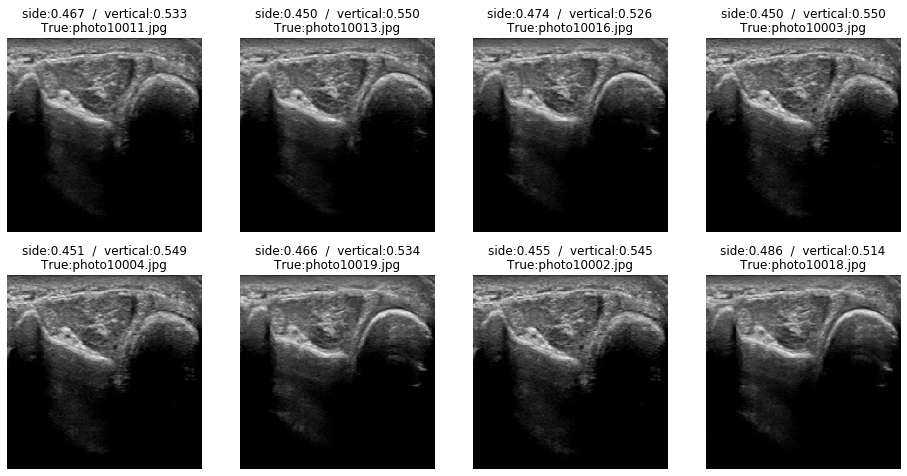

In [11]:
# 評価用画像の表
show_test_samples(
    x_test, probs,
    img_itr_train.class_indices,
    true_labels
)

/Users/takahashi/.anyenv/envs/pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


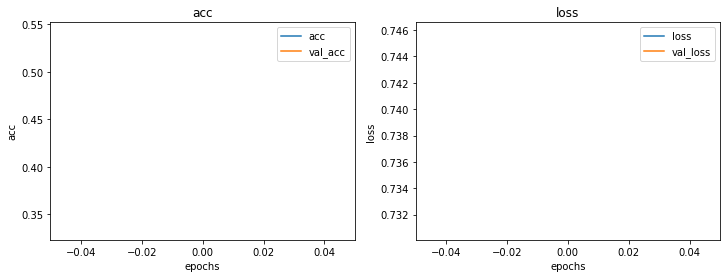

In [12]:
# 学習曲線の表示
plot_learningcurve_from_csv(csv_filepath)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [14]:
model.save(MODELFILE)

In [15]:
model2 = build_transfer_model(vgg16)
model2.load_weights(MODELFILE)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      